# 02. 에란겔 플레이어 전략 세그먼트 분류

## 분석 흐름
```
피처 테이블 로드
  → 파생 피처 생성 (kill_rate, move_speed, heal_boost_use)
  → Winsorizing (1~99 퍼센타일 클리핑, 데이터 손실 없음)
  → Robust Z-Score 정규화 (이상치 강건)
  → 페르소나 점수 계산 (4개 타입 정의 기반)
  → Margin 임계값으로 uncertain 분리
  → UMAP 시각화 (분류 후 시각적 확인용)
  → 모델 저장
```

## 4개 전략 페르소나
| 페르소나 | 핵심 특징 |
|----------|-----------|
| 🏃 중앙 점령형 | 비행기 경로 중앙 낙하, 핫드랍, 선점 로테이션, 높은 킬 |
| 🌿 외곽 운영형 | 외곽 낙하, 저밀도 지역, 안전구역 근접, 힐템 활용 |
| ⚔️ 하이리스크 어태커 | 극단적 핫드랍, 매우 높은 킬+딜, 빠른 이동 |
| 🦅 게릴라 운영형 | 차량 비선호, 존타기 수용, 후행 로테이션, 힐 중심 |

## HDBSCAN을 사용하지 않는 이유
HDBSCAN은 "데이터 구조에서 자연스러운 클러스터를 탐색"하는 도구입니다.  
이 데이터에서는 반복 실험 결과 항상 2~3개 덩어리만 생성되어 의미 있는 분류가 어려웠습니다.  
우리의 목적은 **이미 정의된 4개 전략 타입으로 분류**하는 것이므로,  
Robust Z-Score 기반 스코어 방식이 더 안정적이고 해석 가능합니다.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.font_manager as fm
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

import umap
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# 이모지 폰트 지정
mpl.rcParams['font.family'] = ['Malgun Gothic', 'Segoe UI Emoji']

BASE_DIR   = r'C:\배그분석'
OUTPUT_DIR = os.path.join(BASE_DIR, 'analysis_output')
MODEL_DIR  = os.path.join(OUTPUT_DIR, 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

print('설정 완료')

설정 완료


In [2]:
# STEP 1: 피처 테이블 로드
df = pd.read_parquet(os.path.join(OUTPUT_DIR, 'erangel_features.parquet'))
print(f'로드 완료: {df.shape[0]:,}행 x {df.shape[1]}열')
display(df.head(3))

로드 완료: 147,673행 x 25열


,matchId,accountId,rotation_timing_score,vehicle_use_ratio,bluezone_exposure_ratio,safezone_proximity_mean,safezone_edge_ratio,altitude_variance,survival_time,total_movement,...,kills,damageDealt,winPlace,win_flag,top3_flag,timeSurvived,walkDistance,rideDistance,heals,boosts
0,001491cf-ad60-4ebc-b6a1-c86bc05959fd,account.00ae636f3f29443490716d28017686d2,0.635235,0.172414,0.126437,1177.286963,0.006873,1430.389772,1719.0,6.582388e+05,...,3.0,249.50539,2.0,0.0,1.0,1766.0,4123.179,4482.5470,4.0,6.0
1,001491cf-ad60-4ebc-b6a1-c86bc05959fd,account.04550355e52549ea99457094928c0316,0.556537,0.147826,0.052174,1486.343883,0.006034,21271.393148,1304.0,9.153429e+05,...,0.0,0.00000,4.0,0.0,1.0,1176.0,2180.932,5912.9204,1.0,5.0
2,001491cf-ad60-4ebc-b6a1-c86bc05959fd,account.09c7523488a6456abbee4404309fa9b4,0.695087,0.491525,0.000000,782.124023,0.004091,12176.072837,1288.0,1.220069e+06,...,1.0,329.19660,5.0,0.0,1.0,1198.0,1521.188,10001.2380,2.0,6.0


In [3]:
# STEP 2: 파생 피처 생성 + 기초 전처리
#
# 이번 버전은 HDBSCAN 방식을 폐기하고
# Robust Z-Score 기반 스코어 세그먼트 방식으로 전면 전환합니다.
#
# [이유]
# - HDBSCAN은 "데이터가 몇 개 덩어리인지 탐색"하는 도구
# - 우리 목적은 이미 정의된 4개 전략 타입에 각 플레이어를 분류하는 것
# - → 스코어 기반 분류가 목적에 더 정확히 부합
#
# [Robust Z-Score란]
# 중앙값(median) + MAD(Median Absolute Deviation) 기반 표준화
# 평균/표준편차보다 이상치에 훨씬 강건 → 극단 플레이어도 안정적으로 처리

# 생존 시간 최소 2분 이상 필터
df_clean = df[df['survival_time'] >= 120].copy()
print(f'생존 2분 이상 필터: {len(df_clean):,}행 ({len(df_clean)/len(df):.1%} 유지)')

# 파생 피처
df_clean['kill_rate']      = df_clean['kills'].fillna(0) / (df_clean['survival_time'] / 60 + 1e-9)
df_clean['move_speed']     = df_clean['walkDistance'].fillna(0) / (df_clean['survival_time'] + 1e-9)
df_clean['heal_boost_use'] = df_clean['heals'].fillna(0) + df_clean['boosts'].fillna(0)

# 결측치 중앙값 대체
fill_cols = [
    'drop_distance_from_path', 'early_enemy_density', 'rotation_timing_score',
    'vehicle_use_ratio', 'bluezone_exposure_ratio', 'safezone_proximity_mean',
    'safezone_edge_ratio', 'altitude_variance',
    'kill_rate', 'move_speed', 'heal_boost_use',
]
for col in fill_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

print('결측치 보완 완료')
print()
print('피처 기초 통계:')
display(df_clean[fill_cols].describe().round(3))

생존 2분 이상 필터: 134,392행 (91.0% 유지)
결측치 보완 완료

피처 기초 통계:


,drop_distance_from_path,early_enemy_density,rotation_timing_score,vehicle_use_ratio,bluezone_exposure_ratio,safezone_proximity_mean,safezone_edge_ratio,altitude_variance,kill_rate,move_speed,heal_boost_use
count,134392.000,134392.000,134392.000,134392.000,134392.000,134392.000,134392.000,134392.000,134392.000,134392.000,134392.000
mean,796.379,4.532,0.549,0.152,0.061,1460.158,0.006,3351.464,0.073,2.072,6.230
std,477.824,5.541,0.076,0.142,0.110,734.835,0.233,5222.483,0.125,0.838,6.226
min,0.016,0.000,0.071,0.000,0.000,61.651,0.000,0.000,0.000,0.000,0.000
25%,390.769,0.000,0.503,0.000,0.000,885.496,0.004,523.926,0.000,1.690,1.000
50%,781.967,3.000,0.546,0.136,0.000,1295.401,0.005,1277.960,0.000,2.116,5.000
75%,1175.856,7.000,0.595,0.250,0.079,1959.509,0.006,2745.457,0.107,2.560,10.000
max,3029.393,44.000,0.974,0.960,1.000,5443.931,72.325,54959.437,2.454,33.892,104.000


In [4]:
# STEP 3: Winsorizing (이상치 클리핑)
#
# 전략 분류에서 극단값은 의미있는 신호입니다.
# (상위 1% 킬률 = 프로급 공격형, 상위 1% 낙하거리 = 극단 외곽형)
# → IQR 제거 대신 1~99 퍼센타일 클리핑으로 데이터 유지 + 분포 안정화

winsor_cols = [
    'drop_distance_from_path', 'early_enemy_density',
    'safezone_proximity_mean', 'altitude_variance',
    'kill_rate', 'move_speed', 'heal_boost_use',
]
for col in winsor_cols:
    lo = df_clean[col].quantile(0.01)
    hi = df_clean[col].quantile(0.99)
    df_clean[col] = df_clean[col].clip(lo, hi)

print(f'Winsorizing 완료 — 데이터 유지: {len(df_clean):,}행 (손실 없음)')
print()

# 간단한 분포 확인
print('Winsorizing 후 주요 피처 범위:')
for col in ['drop_distance_from_path', 'early_enemy_density', 'kill_rate']:
    print(f'  {col:<35} min={df_clean[col].min():.3f}  max={df_clean[col].max():.3f}')

Winsorizing 완료 — 데이터 유지: 134,392행 (손실 없음)

Winsorizing 후 주요 피처 범위:
  drop_distance_from_path             min=13.725  max=1794.185
  early_enemy_density                 min=0.000  max=24.000
  kill_rate                           min=0.000  max=0.558


In [5]:
# STEP 4: Robust Z-Score 계산
#
# robust_z(x) = (x - median(x)) / (1.4826 * MAD(x))
# - 1.4826: 정규분포 가정 하의 보정 상수 (MAD → 표준편차 스케일 변환)
# - MAD = 0이면 1.0으로 대체 (상수 피처 보호)
#
# 각 피처를 동일 스케일로 변환해야 점수 계산 시 특정 피처가 지배하지 않음

def robust_z(s: pd.Series) -> pd.Series:
    med = s.median()
    mad = (s - med).abs().median()
    mad = mad if mad != 0 else 1.0
    return (s - med) / (1.4826 * mad)

z = pd.DataFrame(index=df_clean.index)
z['drop']    = robust_z(df_clean['drop_distance_from_path'])
z['density'] = robust_z(df_clean['early_enemy_density'])
z['rot']     = robust_z(df_clean['rotation_timing_score'])
z['vehicle'] = robust_z(df_clean['vehicle_use_ratio'])
z['blue']    = robust_z(df_clean['bluezone_exposure_ratio'])
z['safe']    = -robust_z(df_clean['safezone_proximity_mean'])   # 음수: 가까울수록 +
z['edge']    = robust_z(df_clean['safezone_edge_ratio'])
z['kill']    = robust_z(df_clean['kill_rate'])
z['speed']   = robust_z(df_clean['move_speed'])
z['heal']    = robust_z(df_clean['heal_boost_use'])

print('Robust Z-Score 계산 완료')
print(f'  shape: {z.shape}')
print()
print('Z-Score 분포 확인 (중앙값은 0에 가까워야 함):')
display(z.describe().round(3))

Robust Z-Score 계산 완료
  shape: (134392, 10)

Z-Score 분포 확인 (중앙값은 0에 가까워야 함):


,drop,density,rot,vehicle,blue,safe,edge,kill,speed,heal
count,134392.000,134392.000,134392.000,134392.000,134392.000,134392.000,134392.000,134392.000,134392.000,134392.000
mean,0.023,0.334,0.058,0.079,0.041,-0.223,0.688,0.048,-0.075,0.200
std,0.816,1.202,1.126,0.710,0.074,0.999,129.551,0.074,1.270,1.018
min,-1.320,-0.674,-7.060,-0.680,0.000,-2.744,-2.602,0.000,-3.285,-0.843
25%,-0.672,-0.674,-0.636,-0.680,0.000,-0.916,-0.672,0.000,-0.662,-0.674
50%,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000
75%,0.677,0.899,0.732,0.566,0.053,0.565,0.678,0.072,0.689,0.843
max,1.739,4.721,6.365,4.106,0.674,1.284,40232.530,0.376,2.924,3.541


In [6]:
# STEP 5: 페르소나 점수 계산 + 세그먼트 라벨링
#
# 4개 페르소나 정의:
# 중앙 점령형         : 낙하↓ + 적밀도↑ + 선점로테이션 + 킬↑ 
# 외곽 운영형         : 낙하↑ + 적밀도↓ + 외곽포지션 + 안전구역근접 + 힐
# 하이리스크 어태커   : 적밀도↑↑ + 킬↑↑ + 이동속도↑ 
# 게릴라 운영형       : 차량↓ + 존타기↑ + 후행로테이션 + 힐↑ 
#
# margin(1등-2등 점수 차) < threshold → 'uncertain' (어느 타입에도 확실하지 않음)

PERSONA_LABELS = {
    'C0_center':   '🏃 중앙 점령형',
    'C1_edge':     '🌿 외곽 운영형',
    'C2_aggro':    '⚔️ 하이리스크 어태커',
    'C3_guerilla': '🦅 게릴라 운영형',
    'uncertain':   '❓ 혼합형',
}

# 점수 계산
# rotation_timing_score: 낮을수록 선점(early) → -z['rot']
scores = pd.DataFrame({
    'C0_center':   z['density'] - z['rot'] - z['drop'] + z['kill'],
    'C1_edge':     z['drop'] - z['density'] + z['edge'] - z['safe'] + z['heal'],
    'C2_aggro':    1.5*z['density'] + 1.5*z['kill'] + z['speed'],
    'C3_guerilla': -z['vehicle'] + z['blue'] + z['rot'] + 0.5*z['heal'],
}, index=df_clean.index)

# argmax로 최고 점수 페르소나 결정
best_persona  = scores.idxmax(axis=1)
best_score    = scores.max(axis=1)
second_score  = scores.apply(lambda r: r.nlargest(2).iloc[-1], axis=1)
margin        = best_score - second_score

# 임계값 설정 (margin < 0.5 → uncertain)
MARGIN_THRESHOLD = 0.5
df_clean['segment']    = best_persona
df_clean['margin']     = margin
df_clean['persona']    = df_clean['segment'].map(PERSONA_LABELS)
df_clean.loc[margin < MARGIN_THRESHOLD, 'segment'] = 'uncertain'
df_clean.loc[margin < MARGIN_THRESHOLD, 'persona'] = PERSONA_LABELS['uncertain']

# 점수 컬럼도 저장
for col in scores.columns:
    df_clean[f'score_{col}'] = scores[col]

# 결과 요약
print(f'세그먼트 분류 완료 (margin threshold={MARGIN_THRESHOLD})')
print()
seg_counts = df_clean['persona'].value_counts()
for persona, cnt in seg_counts.items():
    print(f'  {persona}: {cnt:,}명 ({cnt/len(df_clean):.1%})')
print()
print(f'※ 혼합형 비율이 너무 높으면 MARGIN_THRESHOLD를 낮추세요 (현재: {MARGIN_THRESHOLD})')
print(f'  혼합형 비율: {(df_clean["segment"]=="uncertain").mean():.1%}')

세그먼트 분류 완료 (margin threshold=0.5)

  🌿 외곽 운영형: 42,316명 (31.5%)
  ❓ 혼합형: 31,296명 (23.3%)
  ⚔️ 하이리스크 어태커: 21,905명 (16.3%)
  🏃 중앙 점령형: 21,896명 (16.3%)
  🦅 게릴라 운영형: 16,979명 (12.6%)

※ 혼합형 비율이 너무 높으면 MARGIN_THRESHOLD를 낮추세요 (현재: 0.5)
  혼합형 비율: 23.3%


In [7]:
# STEP 6: 세그먼트별 피처 프로파일
#
# uncertain 제외 4개 세그먼트의 중앙값 비교
# → 각 페르소나가 실제로 정의와 맞게 분류됐는지 검증

FEATURE_COLS_DISPLAY = [
    'drop_distance_from_path', 'early_enemy_density', 'rotation_timing_score',
    'vehicle_use_ratio', 'bluezone_exposure_ratio', 'safezone_proximity_mean',
    'safezone_edge_ratio', 'altitude_variance', 'kill_rate', 'move_speed', 'heal_boost_use',
]

profile = (
    df_clean[df_clean['segment'] != 'uncertain']
    .groupby('persona')[FEATURE_COLS_DISPLAY]
    .median()
    .round(3)
)

print('페르소나별 피처 중앙값:')
display(profile)
print()

# 피처별로 어떤 페르소나가 최고값/최저값인지 확인
print('피처별 최고/최저 페르소나:')
for col in FEATURE_COLS_DISPLAY:
    hi = profile[col].idxmax()
    lo = profile[col].idxmin()
    print(f'  {col:<35} 최고: {hi}  최저: {lo}')

페르소나별 피처 중앙값:


,drop_distance_from_path,early_enemy_density,rotation_timing_score,vehicle_use_ratio,bluezone_exposure_ratio,safezone_proximity_mean,safezone_edge_ratio,altitude_variance,kill_rate,move_speed,heal_boost_use
persona,,,,,,,,,,,
⚔️ 하이리스크 어태커,720.725,9.0,0.546,0.000,0.000,1347.314,0.004,463.755,0.045,2.778,2.0
🌿 외곽 운영형,1179.262,0.0,0.545,0.232,0.074,1672.599,0.006,1760.846,0.000,2.031,8.0
🏃 중앙 점령형,356.177,5.0,0.490,0.058,0.000,1059.189,0.004,961.261,0.000,1.755,2.0
🦅 게릴라 운영형,667.979,0.0,0.654,0.122,0.000,890.220,0.004,1552.656,0.036,1.983,6.0



피처별 최고/최저 페르소나:
  drop_distance_from_path             최고: 🌿 외곽 운영형  최저: 🏃 중앙 점령형
  early_enemy_density                 최고: ⚔️ 하이리스크 어태커  최저: 🌿 외곽 운영형
  rotation_timing_score               최고: 🦅 게릴라 운영형  최저: 🏃 중앙 점령형
  vehicle_use_ratio                   최고: 🌿 외곽 운영형  최저: ⚔️ 하이리스크 어태커
  bluezone_exposure_ratio             최고: 🌿 외곽 운영형  최저: ⚔️ 하이리스크 어태커
  safezone_proximity_mean             최고: 🌿 외곽 운영형  최저: 🦅 게릴라 운영형
  safezone_edge_ratio                 최고: 🌿 외곽 운영형  최저: ⚔️ 하이리스크 어태커
  altitude_variance                   최고: 🌿 외곽 운영형  최저: ⚔️ 하이리스크 어태커
  kill_rate                           최고: ⚔️ 하이리스크 어태커  최저: 🌿 외곽 운영형
  move_speed                          최고: ⚔️ 하이리스크 어태커  최저: 🏃 중앙 점령형
  heal_boost_use                      최고: 🌿 외곽 운영형  최저: ⚔️ 하이리스크 어태커


In [8]:
# STEP 7: 승률 분석

result_cols_check = ['win_flag','top3_flag','kills','damageDealt','winPlace']
avail = [c for c in result_cols_check if c in df_clean.columns]

seg_results = (
    df_clean[df_clean['segment'] != 'uncertain']
    .groupby('persona')
    .agg(
        n_players   = ('win_flag', 'count'),
        win_rate    = ('win_flag', 'mean'),
        top3_rate  = ('top3_flag', 'mean'),
        avg_kills   = ('kills', 'mean'),
        avg_damage  = ('damageDealt', 'mean'),
        avg_winplace= ('winPlace', 'mean'),
    )
    .round(3)
    .reset_index()
)

print('페르소나별 게임 결과:')
display(seg_results.sort_values('win_rate', ascending=False))

페르소나별 게임 결과:


,persona,n_players,win_rate,top3_rate,avg_kills,avg_damage,avg_winplace
3,🦅 게릴라 운영형,15697,0.141,0.858,1.302,268.688,5.645
1,🌿 외곽 운영형,41443,0.069,0.747,1.074,190.060,7.470
0,⚔️ 하이리스크 어태커,21905,0.040,0.348,1.178,186.707,12.266
2,🏃 중앙 점령형,17556,0.037,0.492,0.989,169.644,10.268


UMAP 시각화용 차원 축소 중... (수분 소요 가능)
UMAP 완료: (134392, 2)


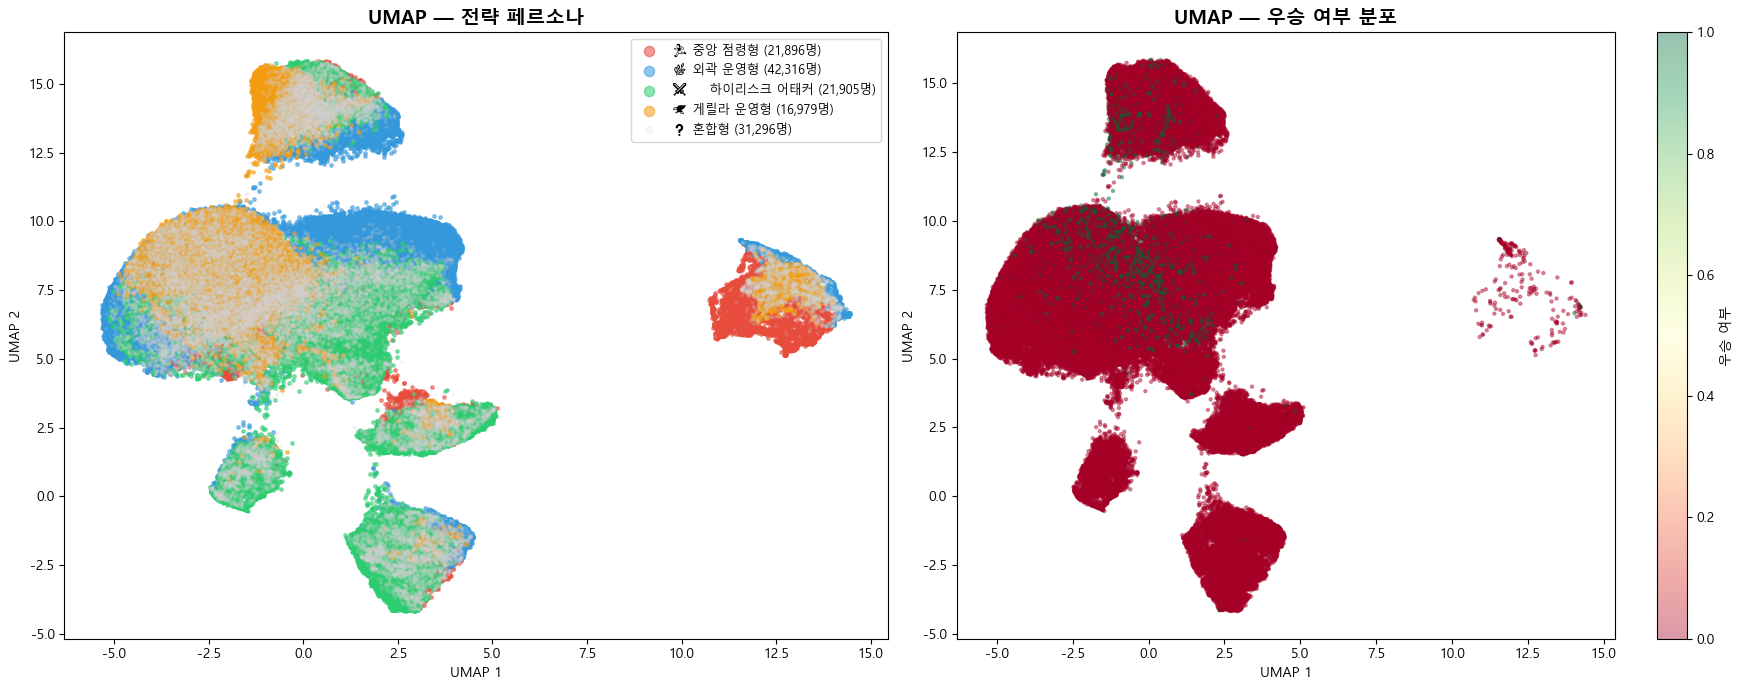

저장 완료: umap_segments.png


In [9]:
# STEP 8: UMAP 시각화 (세그먼트 색상)
#
# UMAP은 이제 분류에 사용하지 않고 시각화 전용으로만 사용
# → 세그먼트가 UMAP 공간에서 어떻게 분포하는지 확인

print('UMAP 시각화용 차원 축소 중... (수분 소요 가능)')

# 시각화용 피처 행렬 (StandardScaler)
feat_matrix = df_clean[FEATURE_COLS_DISPLAY].values
imputer = SimpleImputer(strategy='median')
scaler  = StandardScaler()
X_vis   = scaler.fit_transform(imputer.fit_transform(feat_matrix))

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.1,
    metric='euclidean',
    random_state=42,
    verbose=False,
)
embedding = reducer.fit_transform(X_vis)
df_clean['umap_x'] = embedding[:, 0]
df_clean['umap_y'] = embedding[:, 1]

print(f'UMAP 완료: {embedding.shape}')

# ── 시각화 ──
COLORS = {
    '🏃 중앙 점령형':       '#E74C3C',
    '🌿 외곽 운영형':       '#3498DB',
    '⚔️ 하이리스크 어태커': '#2ECC71',
    '🦅 게릴라 운영형':     '#F39C12',
    '❓ 혼합형':            'lightgray',
}

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 왼쪽: 페르소나 색상
ax = axes[0]
for persona, color in COLORS.items():
    mask = df_clean['persona'] == persona
    if not mask.any():
        continue
    alpha = 0.15 if persona == '❓ 혼합형' else 0.55
    size  = 3     if persona == '❓ 혼합형' else 6
    ax.scatter(
        df_clean.loc[mask, 'umap_x'],
        df_clean.loc[mask, 'umap_y'],
        c=color, alpha=alpha, s=size, label=f'{persona} ({mask.sum():,}명)',
    )
ax.set_title('UMAP — 전략 페르소나', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', markerscale=3, fontsize=9)
ax.set_xlabel('UMAP 1'); ax.set_ylabel('UMAP 2')

# 오른쪽: 승률 히트맵
ax2 = axes[1]
non_unc = df_clean[df_clean['segment'] != 'uncertain']
sc = ax2.scatter(
    non_unc['umap_x'], non_unc['umap_y'],
    c=non_unc['win_flag'], cmap='RdYlGn',
    alpha=0.4, s=5, vmin=0, vmax=1,
)
plt.colorbar(sc, ax=ax2, label='우승 여부')
ax2.set_title('UMAP — 우승 여부 분포', fontsize=14, fontweight='bold')
ax2.set_xlabel('UMAP 1'); ax2.set_ylabel('UMAP 2')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'umap_segments.png'), dpi=150, bbox_inches='tight')
plt.show()
print('저장 완료: umap_segments.png')

그릴 페르소나 (4개): ['🏃 중앙 점령형', '🌿 외곽 운영형', '⚔️ 하이리스크 어태커', '🦅 게릴라 운영형']


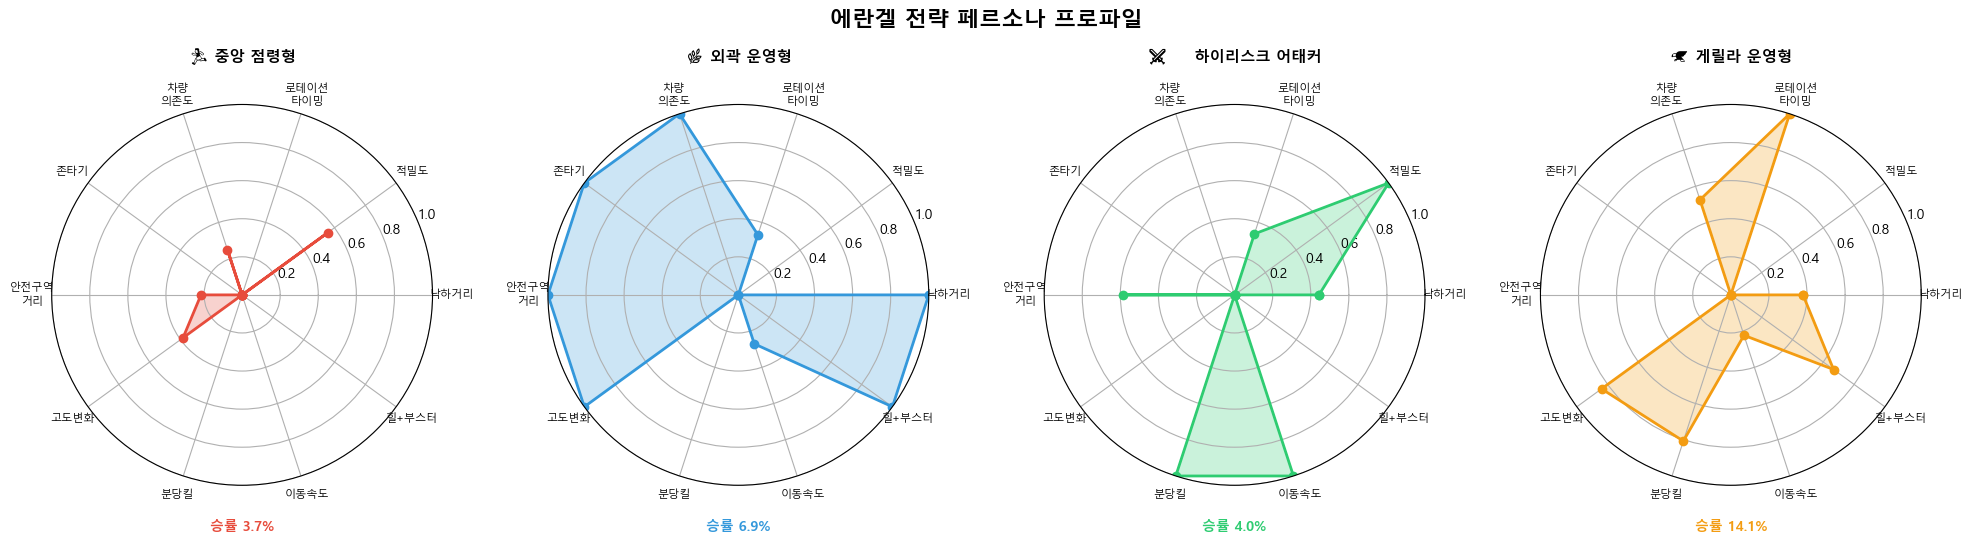

저장 완료: segment_radar.png

정규화된 피처 중앙값 (0~1, 0=4개 중 최저 1=4개 중 최고):
              drop_distance_from_path  early_enemy_density  rotation_timing_score  vehicle_use_ratio  bluezone_exposure_ratio  safezone_proximity_mean  altitude_variance  kill_rate  move_speed  heal_boost_use
persona                                                                                                                                                                                                         
⚔️ 하이리스크 어태커                    0.443                1.000                  0.337              0.000                      0.0                    0.584              0.000      1.000       1.000           0.000
🌿 외곽 운영형                        1.000                0.000                  0.332              1.000                      1.0                    1.000              1.000      0.000       0.270           1.000
🏃 중앙 점령형                        0.000                0.556                  0.000              0.2

In [10]:
# STEP 9: 레이더 차트 — 페르소나 프로파일
#
# [버그 수정]
# 기존 코드: name_map으로 이모지를 제거한 뒤 PLOT_ORDER와 매칭 시도
#   → profile_norm.index는 이모지 포함 / PLOT_ORDER는 이모지 없음
#   → valid_order = [] → 레이더 차트가 빈 상태로 저장됨
# 수정: name_map/rename 완전 제거, PERSONA_LABELS 기반으로 순서 통일

RADAR_COLS = [
    'drop_distance_from_path', 'early_enemy_density', 'rotation_timing_score',
    'vehicle_use_ratio', 'bluezone_exposure_ratio', 'safezone_proximity_mean',
    'altitude_variance', 'kill_rate', 'move_speed', 'heal_boost_use',
]
RADAR_LABELS = [
    '낙하거리', '적밀도', '로테이션\n타이밍', '차량\n의존도', '존타기',
    '안전구역\n거리', '고도변화', '분당킬', '이동속도', '힐+부스터',
]

profile_radar = (
    df_clean[df_clean['segment'] != 'uncertain']
    .groupby('persona')[RADAR_COLS]
    .median()
)

# 피처별 min-max 정규화
# 0 = 4개 페르소나 중 해당 피처 최저 (버그 아님, 상대적 최저를 의미)
# 1 = 4개 페르소나 중 해당 피처 최고
profile_norm = (profile_radar - profile_radar.min()) / (
    profile_radar.max() - profile_radar.min() + 1e-9
)

# ── PERSONA_LABELS 정의 순서대로 정렬 (이모지 포함 그대로 사용) ──
PLOT_ORDER = [v for k, v in PERSONA_LABELS.items() if k != 'uncertain']
valid_order = [p for p in PLOT_ORDER if p in profile_norm.index]
print(f"그릴 페르소나 ({len(valid_order)}개): {valid_order}")

PLOT_COLORS = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12']

N      = len(RADAR_COLS)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist() + [0]

fig, axes = plt.subplots(
    1, len(valid_order),
    figsize=(5 * len(valid_order), 5),
    subplot_kw={'polar': True},
)
if len(valid_order) == 1:
    axes = [axes]

for idx, persona in enumerate(valid_order):
    ax    = axes[idx]
    color = PLOT_COLORS[idx % len(PLOT_COLORS)]
    vals  = profile_norm.loc[persona, RADAR_COLS].tolist() + [profile_norm.loc[persona, RADAR_COLS[0]]]

    ax.plot(angles, vals, 'o-', linewidth=2, color=color)
    ax.fill(angles, vals, alpha=0.25, color=color)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(RADAR_LABELS, fontsize=8)
    ax.set_ylim(0, 1)
    ax.set_title(persona, fontsize=11, fontweight='bold', pad=15)

    wr_row = seg_results[seg_results['persona'] == persona]
    if not wr_row.empty:
        ax.text(0.5, -0.12,
                f'승률 {wr_row["win_rate"].values[0]:.1%}',
                transform=ax.transAxes, ha='center',
                fontsize=10, color=color, fontweight='bold')

plt.suptitle('에란겔 전략 페르소나 프로파일', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'segment_radar.png'), dpi=150, bbox_inches='tight')
plt.show()
print('저장 완료: segment_radar.png')
print()
print("정규화된 피처 중앙값 (0~1, 0=4개 중 최저 1=4개 중 최고):")
print(profile_norm.round(3).to_string())

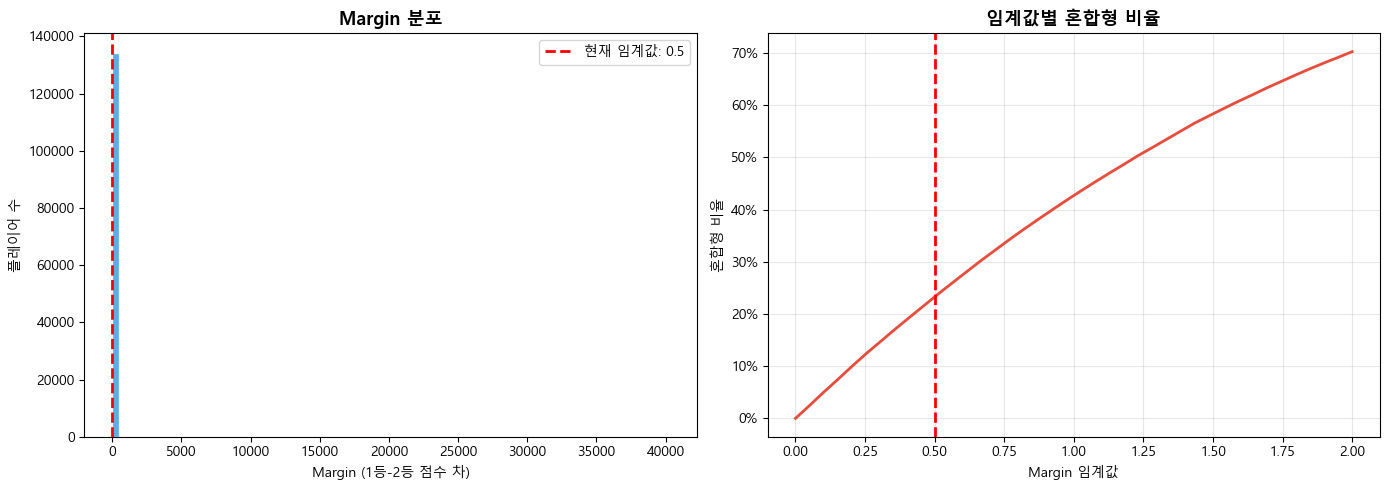

현재 임계값 0.5 기준:
  분류된 플레이어: 76.7%
  혼합형(uncertain): 23.3%

MARGIN_THRESHOLD를 조정하려면 Cell 6(STEP 5)의 값을 변경 후 Cell 6부터 재실행하세요.


In [11]:
# STEP 10: Margin 분포 시각화 + 임계값 튜닝 가이드
#
# margin = 1등 페르소나 점수 - 2등 페르소나 점수
# 값이 클수록 해당 플레이어의 타입이 명확함
# 0.5 임계값이 적절한지 시각적으로 확인

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 왼쪽: margin 히스토그램
ax = axes[0]
ax.hist(df_clean['margin'], bins=80, color='#3498DB', edgecolor='white', alpha=0.8)
ax.axvline(MARGIN_THRESHOLD, color='red', linestyle='--', linewidth=2,
           label=f'현재 임계값: {MARGIN_THRESHOLD}')
ax.set_xlabel('Margin (1등-2등 점수 차)')
ax.set_ylabel('플레이어 수')
ax.set_title('Margin 분포', fontsize=13, fontweight='bold')
ax.legend()

# 오른쪽: 임계값별 uncertain 비율 + 4개 세그먼트 비율 변화
ax2 = axes[1]
thresholds = np.linspace(0, 2.0, 40)
unc_rates = [(df_clean['margin'] < t).mean() for t in thresholds]
ax2.plot(thresholds, unc_rates, color='#E74C3C', linewidth=2)
ax2.axvline(MARGIN_THRESHOLD, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Margin 임계값')
ax2.set_ylabel('혼합형 비율')
ax2.set_title('임계값별 혼합형 비율', fontsize=13, fontweight='bold')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'margin_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f'현재 임계값 {MARGIN_THRESHOLD} 기준:')
print(f'  분류된 플레이어: {(df_clean["margin"] >= MARGIN_THRESHOLD).mean():.1%}')
print(f'  혼합형(uncertain): {(df_clean["margin"] < MARGIN_THRESHOLD).mean():.1%}')
print()
print('MARGIN_THRESHOLD를 조정하려면 Cell 6(STEP 5)의 값을 변경 후 Cell 6부터 재실행하세요.')

In [12]:
# STEP 11: 모델 저장
#
# 새 데이터에 동일한 세그먼트 분류를 적용하려면
# robust_z 함수와 각 피처의 median/MAD 값이 필요합니다.
# → fit_stats 딕셔너리로 저장

# 피처별 median / MAD 저장 (새 데이터 적용 시 재사용)
fit_stats = {}
for col in FEATURE_COLS_DISPLAY:
    med = df_clean[col].median()
    mad = (df_clean[col] - med).abs().median()
    mad = mad if mad != 0 else 1.0
    fit_stats[col] = {'median': med, 'mad': mad}

model_bundle = {
    'reducer':          reducer,        # UMAP (시각화 전용)
    'scaler':           scaler,
    'imputer':          imputer,
    'feature_cols':     FEATURE_COLS_DISPLAY,
    'fit_stats':        fit_stats,      # robust_z 재적용용
    'margin_threshold': MARGIN_THRESHOLD,
    'persona_labels':   PERSONA_LABELS,
    'profile':          profile,
    'seg_results':      seg_results,
}

with open(os.path.join(MODEL_DIR, 'erangel_model.pkl'), 'wb') as f:
    pickle.dump(model_bundle, f)

df_clean.to_parquet(os.path.join(OUTPUT_DIR, 'erangel_clustered.parquet'), index=False)

print('저장 완료!')
print(f'  모델: {MODEL_DIR}/erangel_model.pkl')
print(f'  데이터: {OUTPUT_DIR}/erangel_clustered.parquet')
print()
print('다음 단계: 03_apply_maps.ipynb')

저장 완료!
  모델: C:\배그분석\analysis_output\models/erangel_model.pkl
  데이터: C:\배그분석\analysis_output/erangel_clustered.parquet

다음 단계: 03_apply_maps.ipynb
